In [1]:
import time
t0start = time.time()
from fastai.collab import *
from fastai.tabular.all import *

In [2]:
random_seed = 209

## Loading and Melting Train and Test Data

Here I read the training and test data and melt it to yield a ```DataFrame``` with three categorical features (```cell_type```, ```sm_name```, and ```gene```) and one target (```value```).

In [3]:
%%time
fn = '/kaggle/input/open-problems-single-cell-perturbations/de_train.parquet'
df_de_train = pd.read_parquet(fn)
train_df = df_de_train.melt(id_vars=['cell_type', 'sm_name'], value_vars=df_de_train.iloc[:,5:].columns, var_name='gene', value_name='value')

CPU times: user 2.78 s, sys: 555 ms, total: 3.34 s
Wall time: 3.54 s


In [4]:
fn = '/kaggle/input/open-problems-single-cell-perturbations/id_map.csv'
df_id_map = pd.read_csv(fn)
fn = '/kaggle/input/open-problems-single-cell-perturbations/sample_submission.csv'
df = pd.read_csv(fn, index_col = 0)

cols_to_add = df_de_train.iloc[:,5:].columns
cols_to_add

df_zeros = pd.DataFrame(0.0, columns=cols_to_add, index=df_id_map.index)
df_zeros

df_id_map_preds = pd.concat([df_id_map, df_zeros], axis=1)
test_df = df_id_map_preds.melt(id_vars=['cell_type', 'sm_name'], value_vars=df_id_map_preds.iloc[:,3:].columns, var_name='gene', value_name='value')

## Load Embeddings

The function ```reduce_emb_dim``` is used to reduce the dimensionality of molecular (```dim = 26```) and gene embeddings (```dim = 1000```) down to 10 components.

In [5]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

def reduce_emb_dim(data, n_comp=35, random_state=42):
    embname = data.columns[1][:-1]
    Y = data.iloc[:,1:]
    scaler = StandardScaler()
    Y_std = scaler.fit_transform(Y)
    reducer = PCA(n_components=n_comp, random_state=random_state)

    Yr = reducer.fit_transform(Y_std)
    column_names = [f'{embname}pca{n_comp}_{i}' for i in range(n_comp)]
    reduced_data = pd.DataFrame(Yr, columns = column_names)
    reduced_data = pd.concat([data.iloc[:, 0], reduced_data], axis=1)
    return reduced_data

In [6]:
cell_embs = pd.read_csv('/kaggle/input/op2-single-cell-perturbations-tabmodnn-embeddings/cell_embeddings_no_pca.csv', index_col = 0)
mol_embs = pd.read_csv('/kaggle/input/op2-single-cell-perturbations-tabmodnn-embeddings/molecular_embeddings_no_pca.csv', index_col = 0)
gene_embs = pd.read_parquet('/kaggle/input/op2-single-cell-perturbations-tabmodnn-embeddings/gene_embeddings_no_pca.parquet')

In [7]:
gene_embs = reduce_emb_dim(gene_embs, n_comp=10, random_state=random_seed)

In [8]:
mol_embs = reduce_emb_dim(mol_embs, n_comp=10, random_state=random_seed)

## Functions

In [9]:
def splitter(df):
    train = df.index[~df['is_valid']].tolist()
    valid = df.index[df['is_valid']].tolist()
    return L(train), L(valid)

The function ```get_train_valid_data``` takes the train and test data as inputs and returns a ```TabularPandas``` object using the ```valid``` scheme and ```split_func``` provided.

In [10]:
def get_train_valid_data(train_data, test_data, valid=None, random_state=None, split_func=splitter):
    train_data['is_valid'] = False
    cont, cat = cont_cat_split(train_data, 1, dep_var='value')
    if valid in ['NK cells', 'T cells CD4+', 'T cells CD8+', 'T regulatory cells']:
        test_compounds = test_data['sm_name'].unique().tolist()
        valid_indices = train_data.loc[(train_data['cell_type']==valid) & train_data['sm_name'].isin(test_compounds)].index.sort_values().tolist()
        train_data.loc[valid_indices, 'is_valid'] = True
        splits = splitter(train_data)
        cont, cat = cont_cat_split(train_data, 1, dep_var='value')
        cat.remove('is_valid')
        to = TabularPandas(train_data, procs=[Categorify, FillMissing], cont_names=cont, cat_names=cat, y_names='value', splits=splits)
    elif type(valid)==float:
        valid_indices = train_data.sample(frac=valid, random_state=random_state).index.sort_values().tolist()
        train_data.loc[valid_indices, 'is_valid'] = True
        splits = splitter(train_data)
        cat.remove('is_valid')
        to = TabularPandas(train_data, procs=[Categorify, FillMissing], cont_names=cont, cat_names=cat, y_names='value', splits=splits)
    else:
        cat.remove('is_valid')
        to = TabularPandas(train_data, procs=[Categorify, FillMissing], cont_names=cont, cat_names=cat, y_names='value', splits=None)
    return to

In [11]:
def rmse(preds, targs): return round(math.sqrt(((targs-preds)**2).mean()), 6)
def m_rmse(m, xs, y): return rmse(m.predict(xs), y)

The ```rf``` function trains a random forest and facilitates quick experimenting.

In [12]:
from sklearn.ensemble import RandomForestRegressor

def rf(xs, y, n_estimators=100, max_samples=0.66, max_features='sqrt', min_samples_leaf=5, **kwargs):
    return RandomForestRegressor(n_jobs=-1, n_estimators=n_estimators, max_samples=max_samples, max_features=max_features, min_samples_leaf=min_samples_leaf, oob_score=True).fit(xs, y)

## Add Embeddings

The following lines merge the embeddings with the train and test data.

In [13]:
train_df_c = pd.merge(train_df, cell_embs, on='cell_type', how='left')
train_df_cm = pd.merge(train_df_c, mol_embs, on='sm_name', how='left')
train_df_cmg = pd.merge(train_df_cm, gene_embs, on='gene', how='left')

In [14]:
test_df_c = pd.merge(test_df, cell_embs, on='cell_type', how='left')
test_df_cm = pd.merge(test_df_c, mol_embs, on='sm_name', how='left')
test_df_cmg = pd.merge(test_df_cm, gene_embs, on='gene', how='left')

## Delete Unused Data

And collect garbage to save some memory.

In [15]:
import gc
del train_df_c
del train_df_cm
del test_df_c
del test_df_cm
del cell_embs
del mol_embs
del gene_embs
gc.collect()

0

## Feature Hierarchie

Convert data and check features for redundancy.

In [16]:
%%time
to = get_train_valid_data(train_df_cmg, test_df_cmg, valid=None, random_state=random_seed)
xs, y = to.train.xs, to.train.y

CPU times: user 4.55 s, sys: 2.16 s, total: 6.71 s
Wall time: 6.71 s


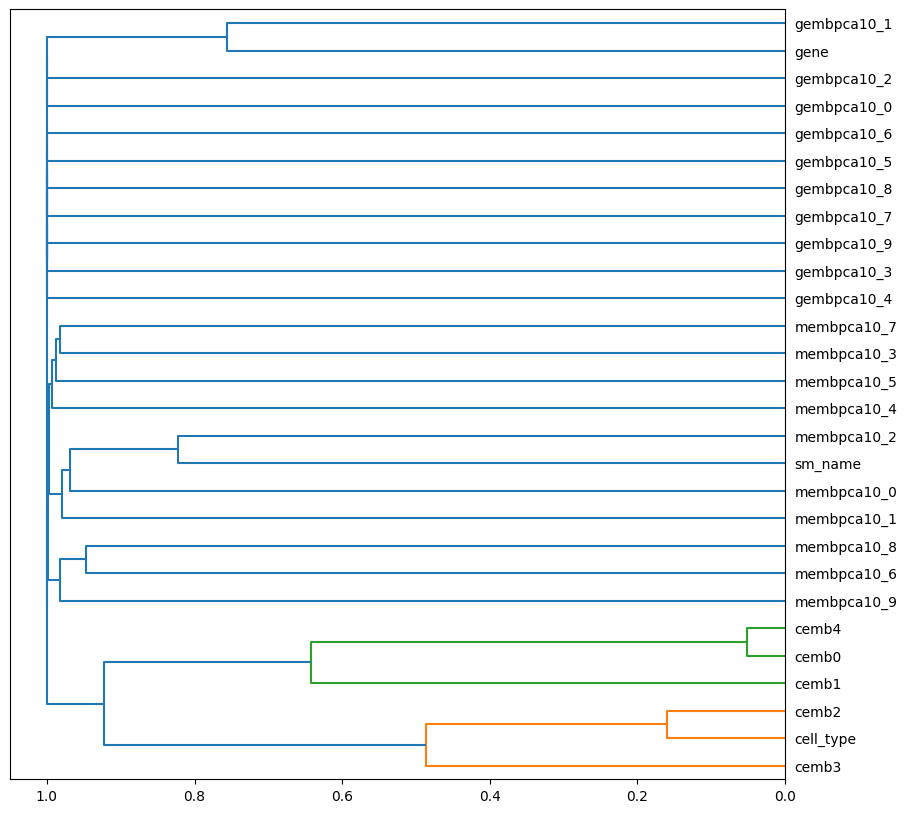

CPU times: user 16.2 s, sys: 449 ms, total: 16.7 s
Wall time: 16.5 s


In [17]:
%%time
from scipy.cluster import hierarchy
from scipy.spatial.distance import squareform
correlation_matrix = xs.corr()
distances = 1 - np.abs(correlation_matrix)
np.fill_diagonal(distances.values, 0)
condensed_distances = squareform(distances)
linkage_matrix = hierarchy.linkage(condensed_distances, method='complete')
plt.figure(figsize=(10,10))
hierarchy.dendrogram(linkage_matrix, labels=xs.columns.tolist(), orientation='left')
plt.show()

## Random Forest All Data

Finally I train a random forest using all training data, predict test scores and submit.

In [18]:
%%time
m = rf(xs, y, random_state=random_seed)
m_rmse(m, xs, y), rmse(m.oob_prediction_, y), m.oob_score_

CPU times: user 1h 50min 38s, sys: 42.3 s, total: 1h 51min 21s
Wall time: 33min 33s


(0.864132, 1.05716, 0.8008796122295169)

## Inference and Submission

In [19]:
test_to = to.new(test_df_cmg)
test_to.process()
test_xs = test_to.xs
test_xs

,cell_type,sm_name,gene,cemb0,cemb1,cemb2,cemb3,cemb4,membpca10_0,membpca10_1,...,gembpca10_0,gembpca10_1,gembpca10_2,gembpca10_3,gembpca10_4,gembpca10_5,gembpca10_6,gembpca10_7,gembpca10_8,gembpca10_9
0,1,1,1,0.231047,0.020016,-0.090010,0.082302,-0.019138,2.524892,-2.715401,...,-5.783795,-1.162065,-5.487894,0.597049,-2.414790,1.982280,-1.08666,-1.206362,-3.901042,1.390772
1,1,2,1,0.231047,0.020016,-0.090010,0.082302,-0.019138,-1.219866,-0.877527,...,-5.783795,-1.162065,-5.487894,0.597049,-2.414790,1.982280,-1.08666,-1.206362,-3.901042,1.390772
2,1,3,1,0.231047,0.020016,-0.090010,0.082302,-0.019138,0.025023,0.075566,...,-5.783795,-1.162065,-5.487894,0.597049,-2.414790,1.982280,-1.08666,-1.206362,-3.901042,1.390772
3,1,4,1,0.231047,0.020016,-0.090010,0.082302,-0.019138,-1.469350,-1.851055,...,-5.783795,-1.162065,-5.487894,0.597049,-2.414790,1.982280,-1.08666,-1.206362,-3.901042,1.390772
4,1,5,1,0.231047,0.020016,-0.090010,0.082302,-0.019138,0.551412,0.157118,...,-5.783795,-1.162065,-5.487894,0.597049,-2.414790,1.982280,-1.08666,-1.206362,-3.901042,1.390772
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4643800,2,142,18211,-0.130559,0.138034,0.096609,0.036904,0.094145,-1.627801,2.048937,...,-7.473646,13.909621,3.644948,-3.208391,0.624002,1.707114,-1.91051,-1.623606,-2.552454,-1.376674
4643801,2,143,18211,-0.130559,0.138034,0.096609,0.036904,0.094145,-0.976956,-0.495422,...,-7.473646,13.909621,3.644948,-3.208391,0.624002,1.707114,-1.91051,-1.623606,-2.552454,-1.376674
4643802,2,144,18211,-0.130559,0.138034,0.096609,0.036904,0.094145,-1.961592,-0.395690,...,-7.473646,13.909621,3.644948,-3.208391,0.624002,1.707114,-1.91051,-1.623606,-2.552454,-1.376674
4643803,2,145,18211,-0.130559,0.138034,0.096609,0.036904,0.094145,0.528172,2.419617,...,-7.473646,13.909621,3.644948,-3.208391,0.624002,1.707114,-1.91051,-1.623606,-2.552454,-1.376674


In [20]:
preds = tensor(m.predict(test_xs))
preds

tensor([ 0.2320,  0.1719,  0.4196,  ..., -0.0962, -0.0292, -0.0715])

In [21]:
preds.min(), preds.max()

(tensor(-18.3912), tensor(29.9948))

In the following step I reshape the predictions back into a 255 x 18211 tensor for submission:

In [22]:
to_submit = preds.view(18211, -1).t().numpy()
submit = pd.DataFrame(to_submit, columns=df_de_train.iloc[:,5:].columns)
submit.index.name = 'id'
submit

,A1BG,A1BG-AS1,A2M,A2M-AS1,A2MP1,A4GALT,AAAS,AACS,AAGAB,AAK1,...,ZUP1,ZW10,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11B,ZYX,ZZEF1
id,,,,,,,,,,,,,,,,,,,,,
0,0.232016,0.110668,0.440268,0.609447,1.480283,1.181870,0.125640,0.108322,-0.123958,0.358815,...,-0.321615,-0.068769,0.195414,0.255237,0.236392,0.174145,0.248805,0.415817,0.088075,0.071194
1,0.171852,0.075148,0.149117,0.214129,1.191716,1.263651,-0.004535,0.158479,0.107841,-0.016537,...,0.113699,0.100706,-0.021103,0.153068,0.192868,0.048186,0.142199,0.146898,0.150609,-0.053352
2,0.419615,0.099909,0.041278,0.107889,1.568029,2.845965,0.050505,0.323187,0.143395,0.005585,...,-0.080905,0.002012,0.061581,0.378854,0.183387,0.273359,0.246448,0.117373,-0.003684,-0.096323
3,0.039393,0.221065,0.108384,0.289663,0.887017,0.646559,-0.087853,0.153870,0.101997,0.334735,...,0.036526,0.116040,0.047634,0.152395,-0.016641,-0.012576,0.086604,0.343730,0.100656,0.057325
4,0.326365,0.070912,0.262907,0.225060,1.144794,1.209496,0.082896,0.187761,0.091944,0.366254,...,-0.190770,0.121339,0.090370,0.181342,0.104310,0.143238,0.246384,0.407660,0.146642,-0.037769
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
250,0.061888,-0.115301,-0.171353,-0.160975,0.083676,-0.050931,0.016860,-0.073320,-0.043505,0.237127,...,-0.081356,-0.184846,-0.305815,-0.091784,-0.009122,-0.069461,-0.117386,0.022502,-0.068701,0.009319
251,0.089803,-0.078957,0.097619,0.335744,0.645069,0.471046,0.003653,0.122890,0.184567,0.221382,...,0.101355,0.039257,-0.402044,-0.019977,0.243823,0.035454,-0.021406,0.079556,-0.206459,-0.084462
252,-0.075844,-0.032259,-0.096995,-0.140546,0.007538,-0.099034,-0.043268,-0.063726,0.072114,0.083702,...,-0.100846,-0.152247,-0.136672,0.003205,-0.073530,-0.033837,0.000309,0.069686,0.030961,-0.096164


In [23]:
submit.to_csv('submission.csv')